In [1]:
# Simglucose Imports
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from simglucose.controller.base import Controller, Action

# Custom imports
from utils.custom import *
from utils.gymenv import T1DSimEnv
from core import config, drl

# Others
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from datetime import datetime
import pickle
import gym
from gym.envs.registration import register

In [2]:
def mv(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
def make_env():    
    register(
    id='simglucose-adult3-v0',
    entry_point='utils.gymenv:T1DSimEnv',
    kwargs={'patient_name': 'adult#002',
            'reward_fun': reward_fun,
            'done_fun': done_fun,
            'scenario': scenario_fun(),
           'seed': 5} # Returning a custom scenario
    )
    env = gym.make('simglucose-adult3-v0')
    return env

In [4]:
def _step(env, action, step, max_step, delay):
    reward = []
    num_step = 0

    # Action Delay
    if delay > 0:
        delayed = 0; terminal = False
        while delayed <= delay and not terminal:
            obs, rew, terminal, info = env.step([0, 0])
            num_step += 1
            delayed += 1
    # Action
    obs, rew, terminal, info = env.step(action)
    num_step += 1
    reward.append(rew)
    meal = info['meal']
    # Till next meal
    while meal <= 0 and not terminal and step + num_step <= max_step:
        obs, rew, terminal, info = env.step([0, 0])
        meal = info['meal']
        num_step += 1
        reward.append(rew)
    return obs, np.mean(reward), terminal, info, num_step

In [37]:
#load_name = 'tt_opt_2_no_delay.p'
#load_file = pickle.load(open(load_name, 'rb'))
env = make_env()

/home/ramtin/anaconda3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Environment '<class 'utils.gymenv.T1DSimEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [45]:
env.step(Action(0, 0))
#env.render(mode='human')

Step(observation=Observation(CGM=135.96224297101645), reward=-0.23898206997378782, done=False, info={'sample_time': 3.0, 'patient_name': 'adult#002', 'meal': 0.0, 'patient_state': array([  0.        ,   0.        ,   0.        , 228.7482655 ,
       105.43793031,   4.08119467,  -0.39854629, 107.01755078,
       107.06949686,   2.92115247,  51.98744214,  52.13717911,
       228.74545358])})

In [38]:
Config = config.config(env, None)
from argparse import Namespace
Config.args = Namespace(delta_state=0, action_sigma=2.0, alpha=0.25, ifCVaR=True, action_delay=0)
Config.power_law = 1
C51 = drl.C51(Config, ifCVaR=Config.args.ifCVaR, p=None)

AttributeError: 'NoneType' object has no attribute 'e_greedy_option'

In [88]:
Config.action_map

array([[0.   , 0.   ],
       [1.875, 0.   ],
       [3.75 , 0.   ],
       [5.625, 0.   ],
       [7.5  , 0.   ]])

In [40]:
Tot_return_cvar = []
#actions = [0, 2, 0, 2] #Policy
for test in range(1):
    terminal = False
    step = 0
    episode_return = []
    Config.max_step = 9*60/(env.env.sensor.sample_time) # Compute the max step
    meal = 0
    observation = Config.process(env.reset(), meal=0)
    o = np.expand_dims([observation], axis=1)
    counter = 0
    while step <= Config.max_step and not terminal:
        
        #values = C51.CVaRopt(o, count=None,\
        #                     alpha=Config.args.alpha, N=Config.CVaRSamples, c=0.0, bonus=0.0)
        #values = C51.Q(observation)
        #action_id = actions[counter]
        action_id = np.random.choice(np.flatnonzero(values == values.max()))
        plt.bar(C51.z, C51.p[observation, action_id, :])
        plt.show()
        action = Config.get_action(action_id)
        #print(action)
        delay = Config.get_delay()

        next_observation, reward, terminal, info, num_step = _step(env,\
             action, step, Config.max_step, delay)
        step += num_step
        BG = next_observation.CGM
        next_observation = Config.process(next_observation, meal=info['meal'])

        episode_return.append(reward)
        if step >= Config.max_step:
            terminal = True
        observation = next_observation
        o = np.expand_dims([observation], axis=1)
        counter += 1
    Tot_return_cvar.append(discounted_return(episode_return, 0.999))
env.render(mode='human')
print(Tot_return_cvar)

NameError: name 'Config' is not defined

(array([ 1.,  1.,  0.,  1.,  1.,  3., 10.,  9., 14., 10.]),
 array([-15.95671386, -14.52370865, -13.09070343, -11.65769822,
        -10.224693  ,  -8.79168779,  -7.35868258,  -5.92567736,
         -4.49267215,  -3.05966693,  -1.62666172]),
 <a list of 10 Patch objects>)

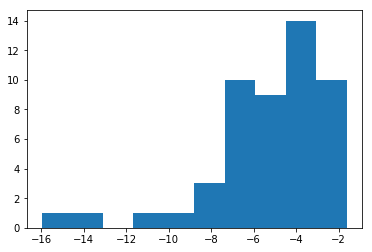

In [43]:
plt.hist(Tot_return, bins=10)

Expected CVaR: -10.6576, CVaR: -8.54616


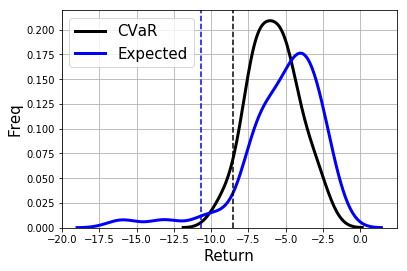

In [74]:
import seaborn as sns
Tot_return = np.load('expected.npy')
Tot_return_cvar = np.array(sorted(np.load('cvar.npy'))[7:-5])
sns.distplot(Tot_return_cvar, bins=15, hist=False, kde_kws={"color": "k", "lw": 3, "label": "CVaR"})
sns.distplot(Tot_return, bins=15, hist=False, kde_kws={"color": "blue", "lw": 3, "label": "Expected"})
print('Expected CVaR: %g, CVaR: %g'%(cv(Tot_return, 0.1), cv(Tot_return_cvar, 0.1)))
plt.xlabel('Return', fontsize=15)
plt.ylabel('Freq', fontsize=15)
plt.axvline(x=-8.54616, linestyle='--', color='k')
plt.axvline(x=-10.6576, linestyle='--', color='blue')
plt.legend(fontsize=15)
plt.grid()

In [49]:
np.save('cvar.npy', Tot_return_cvar)

In [44]:
np.save('expected.npy', Tot_return)

Text(0.5,1,'Random Seed = 3, Expected Return')

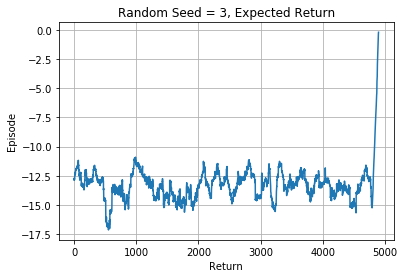

In [18]:
load_name = 'cvar_sigma_2_delay_20_1.p'
load_file = pickle.load(open(load_name, 'rb'))
plt.plot(mv(load_file['returns'], 100))
plt.xlabel('Return')
plt.ylabel('Episode')
plt.grid()
#plt.xlim([0, 2000])
#plt.ylim([-25, 0])
plt.title('Random Seed = 3, Expected Return')

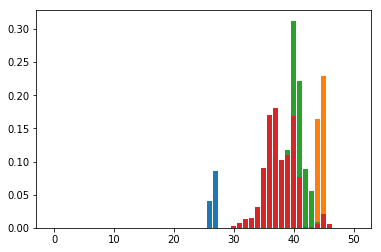

In [19]:
plt.bar(np.arange(51), load_file["p"][16, 0, :])
plt.bar(np.arange(51), load_file["p"][16, 1, :])
plt.bar(np.arange(51), load_file["p"][16, 2, :])
plt.bar(np.arange(51), load_file["p"][16, 3, :])
plt.show()

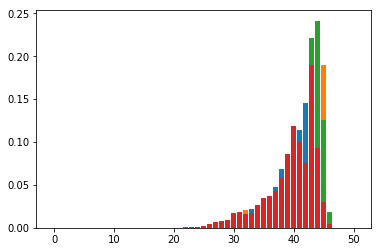

In [31]:
plt.bar(np.arange(51), load_file["p"][14, 0, :])
plt.bar(np.arange(51), load_file["p"][14, 1, :])
plt.bar(np.arange(51), load_file["p"][14, 2, :])
plt.bar(np.arange(51), load_file["p"][14, 3, :])
plt.show()

In [5]:
def cv(res, alpha=0.25):
    cvar = np.zeros(res.shape[0])
    var = np.sort(res)[int(len(res) * alpha)]
    idx = np.where(res <= var)
    cvar = np.mean(res[idx])
    return cvar

Expected CVaR: -6.1487, CVaR: -33.5776


/home/ramtin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ramtin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


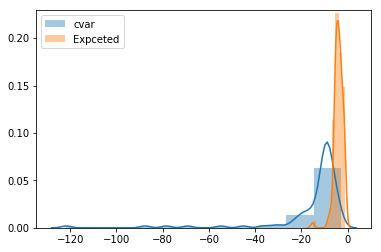

In [7]:
import seaborn as sns
Tot_return = np.load('expected_sigma_0_delay_20_1.npy')
Tot_return_cvar = np.load('cvar_sigma_0_delay_20_1.npy')
sns.distplot(Tot_return_cvar, bins=10, label='cvar')
sns.distplot(Tot_return, bins=10, label='Expceted')
print('Expected CVaR: %g, CVaR: %g'%(cv(Tot_return, 0.25), cv(Tot_return_cvar, 0.25)))
plt.legend()
#plt.xlim([-40, 10])

Expected CVaR: -16.9043, CVaR: -40.0287


/home/ramtin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ramtin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


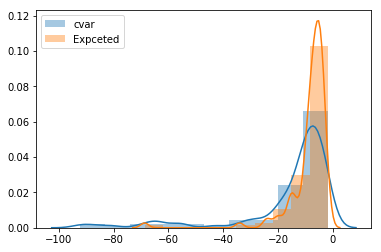

In [6]:
import seaborn as sns
Tot_return = np.load('expected_sigma_2_delay_20_1.npy')
Tot_return_cvar = np.load('test_opt_05_delay.npy')
sns.distplot(Tot_return_cvar, bins=10, label='cvar')
sns.distplot(Tot_return, bins=10, label='Expceted')
print('Expected CVaR: %g, CVaR: %g'%(cv(Tot_return, 0.25), cv(Tot_return_cvar, 0.25)))
plt.legend()
#plt.xlim([-40, 10])

Expected CVaR: -16.9043, CVaR: -40.0287


/home/ramtin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ramtin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


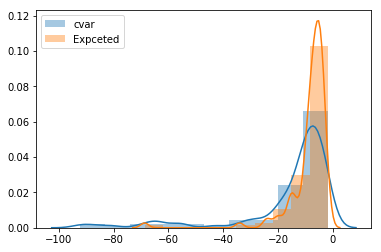

In [27]:
import seaborn as sns
Tot_return = np.load('expected_sigma_2_delay_20_1.npy')
Tot_return_cvar = np.load('test_opt_05_delay.npy')
sns.distplot(Tot_return_cvar, bins=10, label='cvar')
sns.distplot(Tot_return, bins=10, label='Expceted')
print('Expected CVaR: %g, CVaR: %g'%(cv(Tot_return, 0.25), cv(Tot_return_cvar, 0.25)))
plt.legend()
#plt.xlim([-40, 10])

Expected CVaR: -11.3623, CVaR: -10.1667


/home/ramtin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ramtin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


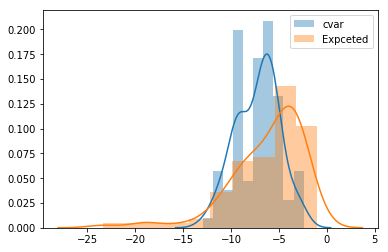

In [8]:
import seaborn as sns
Tot_return = np.load('expected_sigma_2_delay_0_1.npy')
Tot_return_cvar = np.load('test_opt_05.npy')
sns.distplot(Tot_return_cvar, bins=10, label='cvar')
sns.distplot(Tot_return, bins=10, label='Expceted')
print('Expected CVaR: %g, CVaR: %g'%(cv(Tot_return, 0.25), cv(Tot_return_cvar, 0.25)))
plt.legend()
#plt.xlim([-40, 10])

/home/ramtin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ramtin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


NameError: name 'cv' is not defined

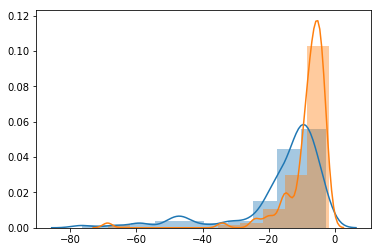

In [7]:
import seaborn as sns
Tot_return = np.load('expected_sigma_2_delay_20_1.npy')
Tot_return_cvar = np.load('test_opt_2_delay.npy')
sns.distplot(Tot_return_cvar, bins=10, label='cvar')
sns.distplot(Tot_return, bins=10, label='Expceted')
print('Expected CVaR: %g, CVaR: %g'%(cv(Tot_return, 0.25), cv(Tot_return_cvar, 0.25)))
plt.legend()
#plt.xlim([-40, 10])

CVaR policy does not have a better CVaR!!!! -- Maybe E-greedy issue?

Or something else!

Expected CVaR: -11.3623, CVaR: -11.6993


/home/ramtin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ramtin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


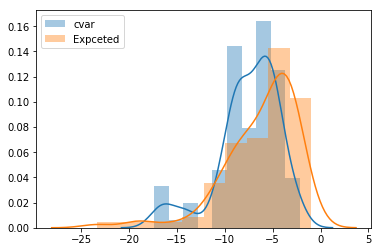

In [9]:
import seaborn as sns
Tot_return = np.load('expected_sigma_2_delay_0_1.npy')
Tot_return_cvar = np.load('test_opt_2.npy')
sns.distplot(Tot_return_cvar, bins=10, label='cvar')
sns.distplot(Tot_return, bins=10, label='Expceted')
print('Expected CVaR: %g, CVaR: %g'%(cv(Tot_return, 0.25), cv(Tot_return_cvar, 0.25)))
plt.legend()
#plt.xlim([-40, 10])

Expected CVaR: -10.8044, CVaR: -13.076


/home/ramtin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ramtin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


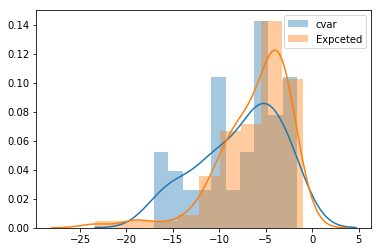

In [12]:
import seaborn as sns
Tot_return = np.load('expected_sigma_2_delay_0_1.npy')
Tot_return_cvar = np.load('tt_opt_2_no_delay.npy')
sns.distplot(Tot_return_cvar, bins=10, label='cvar')
sns.distplot(Tot_return, bins=10, label='Expceted')
print('Expected CVaR: %g, CVaR: %g'%(cv(Tot_return, 0.3), cv(Tot_return_cvar, 0.3)))
plt.legend()
#plt.xlim([-40, 10])

In [6]:
import seaborn as sns
sns.set()

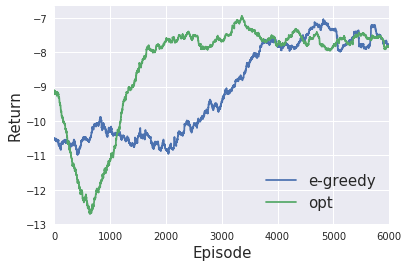

In [12]:
load_name = 'action1_expected_1_delay_5.p'
load_file = pickle.load(open(load_name, 'rb'))
num = 6900
ret = load_file['returns'][:num]
plt.plot(mv(ret, 600), label='e-greedy')
plt.xlabel('Return')
plt.ylabel('Episode')

load_name = 'action1_opt_1_delay_5.p'
load_file = pickle.load(open(load_name, 'rb'))
ret2 = load_file['returns'][:num]
plt.plot(mv(ret2, 600), label='opt')
plt.ylabel('Return', fontsize=15)
plt.xlabel('Episode', fontsize=15)
plt.xlim([0, 6000])
plt.legend(fontsize=15)
#plt.ylim([-25, 0])

In [15]:
cv_ret = ret.reshape((150, -1))
c = np.zeros(150)
for i in range(150):
    c[i] = cv(cv_ret[i, :])
    
cv_ret2 = ret2.reshape((150, -1))
c2 = np.zeros(150)
for i in range(150):
    c2[i] = cv(cv_ret2[i, :])

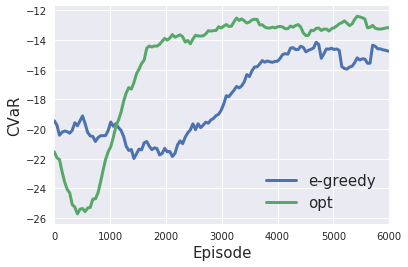

In [18]:
ep = np.arange(150) * num/150
plt.plot(ep[:-19], mv(c, 20), label='e-greedy', linewidth = 3)
plt.plot(ep[:-19], mv(c2, 20), label='opt', linewidth = 3)
plt.ylabel('CVaR', fontsize=15)
plt.xlabel('Episode', fontsize=15)
plt.xlim([0, 6000])
plt.legend(fontsize=15)

<BarContainer object of 51 artists>

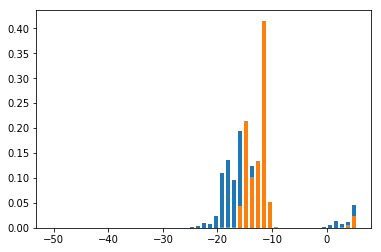

In [14]:
load_name = 'action1_opt_1_delay_5.p'
load_file = pickle.load(open(load_name, 'rb'))
#plt.bar(np.linspace(-50, 5, 51), load_file["p"][14, 0, :])
#plt.bar(np.linspace(-50, 5, 51), load_file["p"][14, 1, :])
#plt.bar(np.linspace(-50, 5, 51), load_file["p"][14, 2, :])
plt.bar(np.linspace(-50, 5, 51), load_file["p"][14, 3, :])

load_name = 'action1_expected_1_delay_5.p'
load_file = pickle.load(open(load_name, 'rb'))
#plt.bar(np.linspace(-50, 5, 51), load_file["p"][14, 0, :])
#plt.bar(np.linspace(-50, 5, 51), load_file["p"][14, 1, :])
#plt.bar(np.linspace(-50, 5, 51), load_file["p"][14, 2, :])
plt.bar(np.linspace(-50, 5, 51), load_file["p"][14, 3, :])

In [17]:
sns.set()

Expected CVaR: -13.0531, CVaR: -12.1802
Expected: -7.03599, CVaR: -7.18693


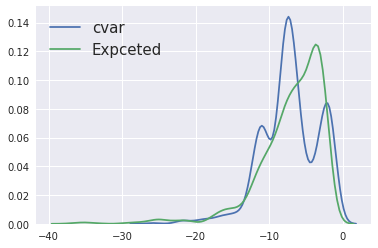

In [25]:
Tot_return = np.load('action1_expected_1_delay_5.npy')
Tot_return = np.concatenate([Tot_return, np.load('action1_expected_1_delay_5_2.npy')])
Tot_return = np.concatenate([Tot_return, np.load('action1_expected_1_delay_5_3.npy')])
Tot_return = np.concatenate([Tot_return, np.load('action1_expected_1_delay_5_4.npy')])
Tot_return = np.concatenate([Tot_return, np.load('action1_expected_1_delay_5_5.npy')])
Tot_return = np.concatenate([Tot_return, np.load('action1_expected_1_delay_5_6.npy')])
Tot_return = np.concatenate([Tot_return, np.load('action1_expected_1_delay_5_7.npy')])

Tot_return_cvar = np.load('action1_opt_1_delay_5.npy')
Tot_return_cvar = np.concatenate([Tot_return_cvar, np.load('action1_opt_1_delay_5_2.npy')])
Tot_return_cvar = np.concatenate([Tot_return_cvar, np.load('action1_opt_1_delay_5_3.npy')])
Tot_return_cvar = np.concatenate([Tot_return_cvar, np.load('action1_opt_1_delay_5_4.npy')])
Tot_return_cvar = np.concatenate([Tot_return_cvar, np.load('action1_opt_1_delay_5_5.npy')])
Tot_return_cvar = np.concatenate([Tot_return_cvar, np.load('action1_opt_1_delay_5_6.npy')])
Tot_return_cvar = np.concatenate([Tot_return_cvar, np.load('action1_opt_1_delay_5_7.npy')])

sns.distplot(Tot_return_cvar, bins=30, label='cvar', hist=False)
sns.distplot(Tot_return, bins=30, label='Expceted', hist=False)
print('Expected CVaR: %g, CVaR: %g'%(cv(Tot_return, 0.25), cv(Tot_return_cvar, 0.25)))
print('Expected: %g, CVaR: %g'%(np.mean(Tot_return), np.mean(Tot_return_cvar)))
plt.legend(fontsize= 15)
#plt.xlim([-40, -10])
#plt.ylim([0, 0.04])

In [26]:
Tot_return_cvar.shape

(1500,)

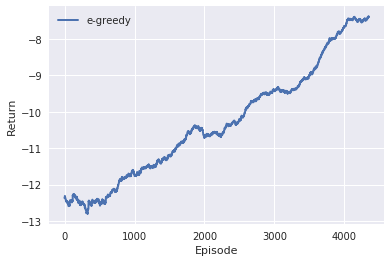

In [36]:
load_name = 'nn_test.p'
num = 4950
load_file = pickle.load(open(load_name, 'rb'))
ret = load_file['returns'][:num, 0]
plt.plot(mv(ret, 600), label='e-greedy', linewidth = 2)
plt.ylabel('Return')
plt.xlabel('Episode')
#plt.grid()
#plt.xlim([0, 3100])
plt.legend()
#plt.ylim([-15, -8])

In [60]:
cv_ret = ret.reshape((150, -1))
c = np.zeros(150)
for i in range(150):
    c[i] = cv(cv_ret[i, :])

Text(0.5,0,'Episode')

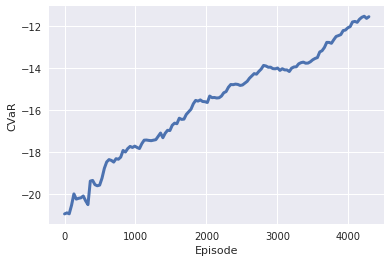

In [68]:
ep = np.arange(150) * num/150
plt.plot(ep[:-19], mv(c, 20), label='e-greedy', linewidth = 3)
plt.ylabel('CVaR')
plt.xlabel('Episode')


No handles with labels found to put in legend.


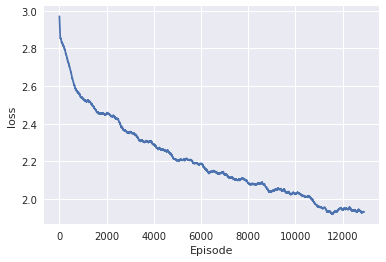

In [62]:
load_name = 'nn_egreedy_1.p'
load_file = pickle.load(open(load_name, 'rb'))
ret = load_file['returns'][:num, 1]
plt.plot(mv(ret, 300))
plt.ylabel('loss')
plt.xlabel('Episode')
#plt.grid()
#plt.xlim([0, 3000])
#plt.ylim([2, 4])
plt.legend()

Text(0.5,0,'Episode')

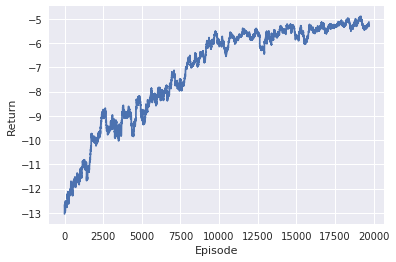

In [20]:
load_name = 'nn_egreedy_1.p'
num =  20000
load_file = pickle.load(open(load_name, 'rb'))
ret_e = load_file['returns'][:num, 0]
plt.plot(mv(ret_e, 300), label='e-greedy')
plt.ylabel('Return')
plt.xlabel('Episode')

# load_name = 'nn_opt_optvalue2.p'
# load_file = pickle.load(open(load_name, 'rb'))
# ret2 = load_file['returns'][:num, 0]
# plt.plot(mv(ret2, 300), label='opt')
# plt.ylabel('Return')
# plt.xlabel('Episode')
# #plt.grid()
# #plt.xlim([0, 3100])
# plt.legend()
# #plt.ylim([-15, -8])

In [46]:
sam = 100
cv_ret = ret_e.reshape((sam, -1))
c_e = np.zeros(sam)
for i in range(sam):
    c_e[i] = cv(cv_ret[i, :])
    
# cv_ret2 = ret2.reshape((sam, -1))
# c2 = np.zeros(sam)
# for i in range(sam):
#     c2[i] = cv(cv_ret2[i, :])

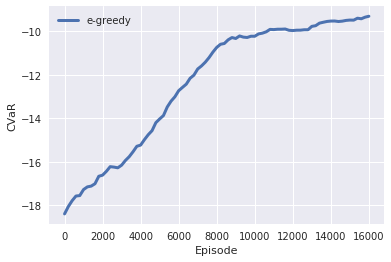

In [22]:
ep_e = np.arange(sam) * num/sam
plt.plot(ep_e[:-19], mv(c_e, 20), label='e-greedy', linewidth = 3)
#plt.plot(ep[:-49], mv(c2, 50), label='opt', linewidth = 3)
plt.ylabel('CVaR')
plt.xlabel('Episode')
plt.legend()

In [13]:
mv(c_e, 20)[-3]

-9.431116158922396

In [14]:
sns.set()

In [15]:
c = 0.01
ep = 10000
pg = 500
N = 1/(np.exp(c/np.sqrt(ep) * pg) - 1)
print(N)
print(2/np.sqrt(N))

19.50416649306586
0.45286243551888516


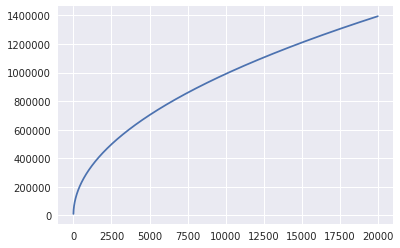

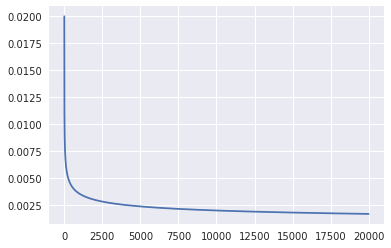

In [16]:
ep = np.arange(1, 20000)
pg = 1
p =  1/(np.exp(0.0001*pg/np.sqrt(ep)) - 1 + 0.00000001)
plt.plot(ep, p)
plt.figure()
plt.plot(ep, 2/np.sqrt(p))

In [17]:
2/np.sqrt(p)

array([0.0200015 , 0.01681941, 0.01519825, ..., 0.00169371, 0.00169369,
       0.00169366])

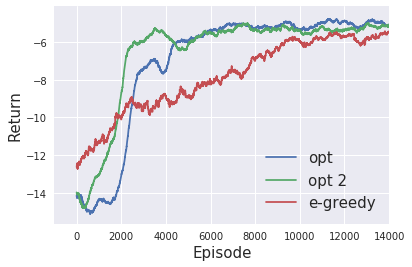

In [42]:
num = 18000
load_name = 'nn_opt_3_optvalue2.p'
load_file = pickle.load(open(load_name, 'rb'))
ret = load_file['returns'][:num, 0]
plt.plot(mv(ret, 500), label='opt')
plt.ylabel('Return', fontsize=15)
plt.xlabel('Episode', fontsize=15)
#plt.grid()
#plt.xlim([0, 3100])
#plt.ylim([-15, -8])

#num = 13000
load_name = 'nn_opt_3_optvalue1.p'
load_file = pickle.load(open(load_name, 'rb'))
ret2 = load_file['returns'][:num, 0]
plt.plot(mv(ret2, 500), label='opt 2')

plt.plot(mv(ret_e, 500), label='e-greedy')
#plt.grid()
plt.xlim([-1000, 14000])
plt.legend(fontsize=15)
#plt.ylim([-15, -8])

In [43]:
sam = 100
cv_ret = ret.reshape((sam, -1))
c = np.zeros(sam)
for i in range(sam):
    c[i] = cv(cv_ret[i, :])
    
cv_ret2 = ret2.reshape((sam, -1))
c2 = np.zeros(sam)
for i in range(sam):
    c2[i] = cv(cv_ret2[i, :])

(-1000, 14000)

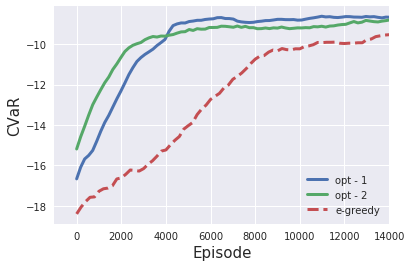

In [51]:
ep = np.arange(sam) * num/sam
plt.plot(ep[:-19], mv(c, 20), label='opt - 1', linewidth = 3)
plt.plot(ep[:-19], mv(c2, 20), label='opt - 2', linewidth = 3)
#print(mv(c_e, 20).shape)
plt.plot(ep_e[:-19], mv(c_e, 20),'--', label='e-greedy', linewidth = 3)
plt.ylabel('CVaR', fontsize=15)
plt.xlabel('Episode', fontsize=15)
plt.legend()
plt.xlim([-1000, 14000])

In [6]:
import seaborn as sns
sns.set()

In [6]:
load_name = 'new_test.p'
load_file = pickle.load(open(load_name, 'rb'))

In [20]:
bg = load_file['Risk'][0:160, :]

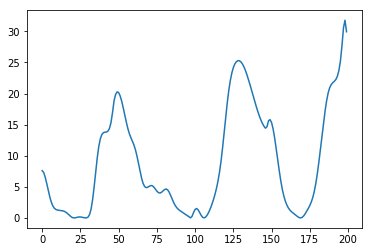

In [23]:
plt.plot(bg[150, :])

In [11]:
bg[0:160, :]

array([[179.30549877, 177.62773321, 173.38766313, ...,  39.        ,
         39.        ,  39.        ],
       [179.30549877, 177.62773321, 173.38766902, ..., 103.56205521,
        103.2874048 , 105.14429939],
       [179.30549877, 177.62771108, 173.3866527 , ...,  48.07120811,
         47.56513669,  49.19660023],
       ...,
       [179.30549877, 177.62773321, 173.38767935, ...,  39.        ,
         39.        ,  39.        ],
       [179.30549877, 177.62773321, 173.38765605, ...,  39.        ,
         39.        ,  39.        ],
       [179.30549877, 177.62773321, 173.38770206, ...,  39.64106622,
         39.07267553,  40.02521648]])

In [55]:
decay = 0.99
decay_step = 5
e = 0.9
steps = np.arange(0, 10000)
dec = e * decay**(steps/decay_step)

decay = 0.99
decay_step = 20
e = 0.9
steps = np.arange(0, 10000)
dec2 = e * decay**(steps/decay_step)

decay = 0.99
decay_step = 2
e = 0.9
steps = np.arange(0, 10000)
dec3 = e * decay**(steps/decay_step)

decay = 0.99
decay_step = 30
e = 0.9
steps = np.arange(0, 10000)
dec4 = e * decay**(steps/decay_step)

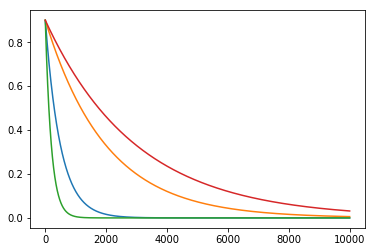

In [56]:
plt.plot(steps, dec)
plt.plot(steps, dec2)
plt.plot(steps, dec3)
plt.plot(steps, dec4)

### Results

In [4]:
def get_res_e(sc, d=True, sam = 100, num=19000):
    if d:
        name1 = 'may14_dis/patient_5_seed_2_e_%d_d.p'%(sc)
        name2 = 'may14_dis/patient_5_seed_3_e_%d_d.p'%(sc)
    else:
        name1 = 'may14_dis/patient_5_seed_2_e_%d_nd.p'%(sc)
        name2 = 'may14_dis/patient_5_seed_3_e_%d_nd.p'%(sc)
        
    data1 = pickle.load(open(name1, 'rb'))['returns']
    data2 = pickle.load(open(name2, 'rb'))['returns']
        
    data1 = data1[:num]; data2 = data2[:num]
    cv1 = data1.reshape((sam, -1)); cv2 = data2.reshape((sam, -1))
    c1 = np.zeros(sam); c2 = np.zeros(sam);
    for i in range(sam):
        c1[i] = cv(cv1[i, :]); c2[i] = cv(cv2[i, :]) 
    returns = (data1 + data2)/2 
    cvs = (c1 + c2)/2
    cvs_ep = np.arange(sam) * len(data1)/sam
    return returns, cvs, cvs_ep

In [5]:
def get_res_o(sc, sam = 100, num=19000, dec = False):
    if not dec:
        name1 = 'may14_dis/patient_5_seed_2_o_%d.p'%(sc)
        name2 = 'may14_dis/patient_5_seed_3_o_%d.p'%(sc)
    else:
        name1 = 'may14_dis/patient_5_seed_2_o_0%d.p'%(sc)
        name2 = 'may14_dis/patient_5_seed_3_o_0%d.p'%(sc)
        
    data1 = pickle.load(open(name1, 'rb'))['returns']
    data2 = pickle.load(open(name2, 'rb'))['returns']
        
    data1 = data1[:num]; data2 = data2[:num]; data2 = data2[:num]; data2 = data2[:num]
    cv1 = data1.reshape((sam, -1)); cv2 = data2.reshape((sam, -1))
    c1 = np.zeros(sam); c2 = np.zeros(sam);
    for i in range(sam):
        c1[i] = cv(cv1[i, :]); c2[i] = cv(cv2[i, :]) 
    returns = (data1 + data2)/2 
    cvs = (c1 + c2)/2
    cvs_ep = np.arange(sam) * len(data1)/sam
    return returns, cvs, cvs_ep

Text(0,0.5,'CVaR')

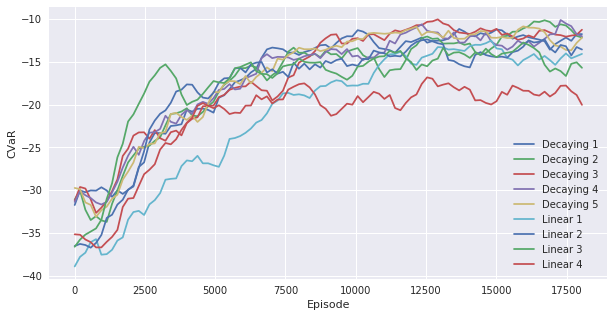

In [202]:
# Plot all the e_greedy:
plt.figure(figsize=(10, 5))
for t in [True, False]:
    for i in range(1, 6):
        if not t and i==5:
            continue
        returns, cvs_e, cvs_ep = get_res_e(int(i), d=t)
        cvs_e = mv(cvs_e, 5)
        cvs_ep = cvs_ep[:-4]
        if t:
            plt.plot(cvs_ep, cvs_e, label = "Decaying %d"%(i))
        else:
            plt.plot(cvs_ep, cvs_e, label = "Linear %d"%(i))
plt.legend()
plt.xlabel('Episode')
plt.ylabel('CVaR')

Best = Linear 5

Text(0,0.5,'CVaR')

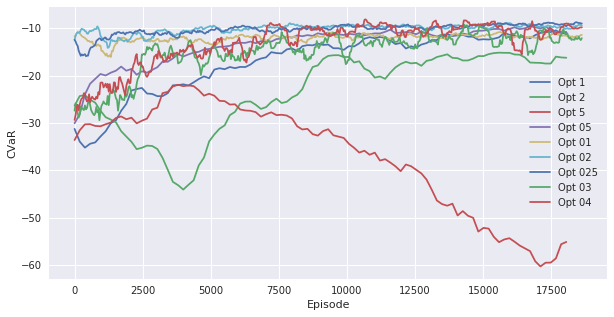

In [156]:
plt.figure(figsize=(10, 5))
for i in [1, 2, 5]:
    returns, cvs_e, cvs_ep = get_res_o(int(i), dec=False)
    cvs_e = mv(cvs_e, 5)
    cvs_ep = cvs_ep[:-4]
    plt.plot(cvs_ep, cvs_e, label = "Opt %d"%(i))

returns, cvs_e, cvs_ep = get_res_o(5, dec=True)
cvs_e = mv(cvs_e, 5)
cvs_ep = cvs_ep[:-4]
plt.plot(cvs_ep, cvs_e, label = "Opt 05")

for i in [1, 2, 25, 3, 4]:
    returns, cvs_e, cvs_ep = get_res_o_new(int(i), dec=False, sam =500)
    cvs_e = mv(cvs_e, 10)
    cvs_ep = cvs_ep[:-9]
    plt.plot(cvs_ep, cvs_e, label = "Opt 0%d"%(i))

plt.legend()
plt.xlabel('Episode')
plt.ylabel('CVaR')

In [11]:
def get_res_o_new(sc, sam = 100, num=19000, dec = False):
    name1 = '/home/ramtin/Desktop/cvar/glucose/results_c51/patient_5_seed_2_o_0%d.p'%(sc)
        
    data1 = pickle.load(open(name1, 'rb'))['returns']
        
    data1 = data1[:num]
    cv1 = data1.reshape((sam, -1))
    c1 = np.zeros(sam)
    for i in range(sam):
        c1[i] = cv(cv1[i, :]) 
    returns = data1
    cvs = c1
    cvs_ep = np.arange(sam) * len(data1)/sam
    return returns, cvs, cvs_ep

Best Opt = 05

Text(0,0.5,'Returns')

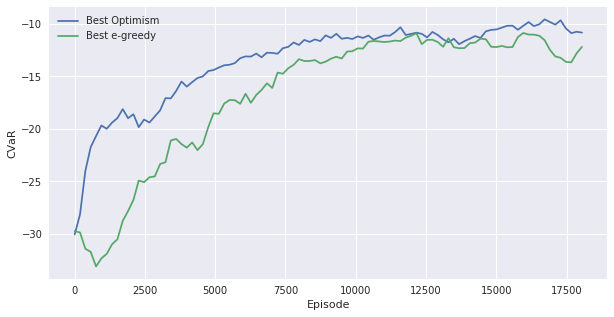

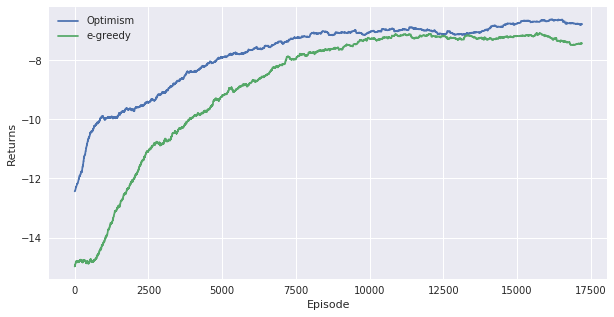

In [201]:
plt.figure(figsize=(10, 5))

returns_o, cvs_e, cvs_ep = get_res_o(5, dec=True)
cvs_e = mv(cvs_e, 5)
cvs_ep = cvs_ep[:-4]
plt.plot(cvs_ep, cvs_e, label = "Best Optimism")

returns_e, cvs_e, cvs_ep = get_res_e(5, d=True)
cvs_e = mv(cvs_e, 5)
cvs_ep = cvs_ep[:-4]
plt.plot(cvs_ep, cvs_e, label = "Best e-greedy")

plt.legend()
plt.xlabel('Episode')
plt.ylabel('CVaR')

plt.figure(figsize=(10, 5))
ep = np.arange(19000)
returns_o = mv(returns_o, 1800)
returns_e = mv(returns_e, 1800)

plt.plot(ep[:-1799], returns_o, label = "Optimism")
plt.plot(ep[:-1799], returns_e, label = "e-greedy")

plt.legend()
plt.xlabel('Episode')
plt.ylabel('Returns')

In [190]:
sc = 1
name1 = 'may14_dis/patient_5_seed_2_o_%d.p'%(sc)
name2 = 'may14_dis/patient_5_seed_3_o_%d.p'%(sc)
name3 = 'may14_dis/patient_5_seed_4_o_%d.p'%(sc)
name4 = 'may14_dis/patient_5_seed_5_o_%d.p'%(sc)

data1 = pickle.load(open(name1, 'rb'))['returns']
data2 = pickle.load(open(name2, 'rb'))['returns']
data3 = pickle.load(open(name3, 'rb'))['returns']
data4 = pickle.load(open(name4, 'rb'))['returns']

data1 = data1[:num]; data2 = data2[:num]; data3 = data3[:num]; data4 = data4[:num]
cv1 = data1.reshape((sam, -1)); cv2 = data2.reshape((sam, -1))
cv3 = data3.reshape((sam, -1)); cv4 = data4.reshape((sam, -1))

c1 = np.zeros(sam); c2 = np.zeros(sam);
c3 = np.zeros(sam); c4 = np.zeros(sam);
for i in range(sam):
    c1[i] = cv(cv1[i, :]); c2[i] = cv(cv2[i, :]) 
    c3[i] = cv(cv3[i, :]); c4[i] = cv(cv4[i, :]) 
returns = (data1 + data2 + data3 + data4)/4
cvs = (c1 + c2 +c3)/3
cvs_ep = np.arange(sam) * len(data1)/sam

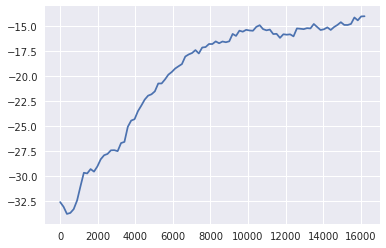

In [191]:
cvs_ee = mv(cvs, 10)
cvs_ep = cvs_ep[:-9]
plt.plot(cvs_ep, cvs_ee, label = "Optimism")

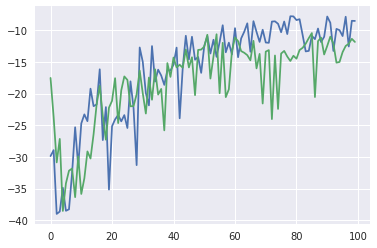

In [194]:
plt.plot(c1)
plt.plot(c2)

## E-greedy Results

In [ ]:
def mv(a, n=3) :
    z = a[0]
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.concatenate([np.expand_dims(z, axis=-1), ret[n - 1:] / n])

In [ ]:
def process_egreedy(patient):
    sample_size = 200
    mv_size = 2
    results = np.zeros((10, 20000))
    cvs = np.zeros((10, sample_size))
    
    for i in range(1, 11):
        load_file = np.load('../results_c51/patient_%d_seed_%d_e.p'%(patient, i))
        results[i-1, :] = load_file['returns']
        reshaped = load_file['returns'].reshape((sample_size, -1))
        for j in range(sample_size):
            cvs[i-1, j] = cv(reshaped[j, :])
            
    cvs_mean = mv(np.mean(cvs, axis=0), mv_size)[:-mv_size]
    cvs_std = mv(np.std(cvs, axis=0), mv_size)[:-mv_size]
    ep = np.arange(sample_size) * 20000/sample_size
    ep = ep[:-(2*mv_size-2)]
    return cvs_mean, cvs_std, results, ep

In [ ]:
def process_opt(patient, opt):
    sample_size = 200
    mv_size = 2
    results = np.zeros((10, 20000))
    cvs = np.zeros((10, sample_size))
    
    for i in range(1, 11):
        load_file = np.load('../results_c51/patient_%d_seed_%d_o%d.p'%(patient, i, opt))
        results[i-1, :] = load_file['returns']
        reshaped = load_file['returns'].reshape((sample_size, -1))
        for j in range(sample_size):
            cvs[i-1, j] = cv(reshaped[j, :])
            
    cvs_mean = mv(np.mean(cvs, axis=0), mv_size)[:-mv_size]
    cvs_std = mv(np.std(cvs, axis=0), mv_size)[:-mv_size]
    ep = np.arange(sample_size) * 20000/sample_size
    ep = ep[:-(2*mv_size-2)]
    return cvs_mean, cvs_std, results, ep

In [32]:
def custom_plot(data, patient ,lim=None):
    import seaborn as sns
    sns.set_style("whitegrid")
    m = 120
    fontsize = 80
    legend_font = 90
    plt.figure(figsize=(30, 15))
    lw = 10
    yticks = {2: [-8, -6, -4, -2], 5: [-40, -30, -20, -10], 6: [-40, -30, -20, -10],  8: [-28, -22, -16, -10]}
    patients = {2: "Child", 5:"Adolescent", 6:"Adolescent", 8:"Adult"}
    for mean, std, eps, tit in data:
        label = [r'$\epsilon$-greedy', 'opt 0.2', 'opt 0.4', 'opt 0.8', 'Optimism']
        color = ['C0', 'green', 'green', 'green', 'green']
        plt.plot(eps[:m], mean[:m], label=label[tit], linewidth=lw, color=color[tit])
        plt.fill_between(eps[:m], mean[:m]-0.4*std[:m], mean[:m]+0.4*std[:m], alpha=0.3, color=color[tit])
    plt.legend(loc=4, fontsize=fontsize)
    plt.ylabel(r'$CVaR_{0.25}$', fontsize=fontsize)
    plt.xlabel('Episodes', fontsize=fontsize)
    plt.title(r'Type 1 Diabetes: %s, Risk level $\alpha$ = 0.25'%(patients[patient]), fontsize=fontsize, y=1.03)
    plt.xticks(fontsize=fontsize)
    plt.yticks(yticks[patient], fontsize=fontsize)
    plt.tight_layout()
    plt.savefig('/home/ramtin/Desktop/CVaR_Patient_%d.pdf'%(patient), format='pdf')

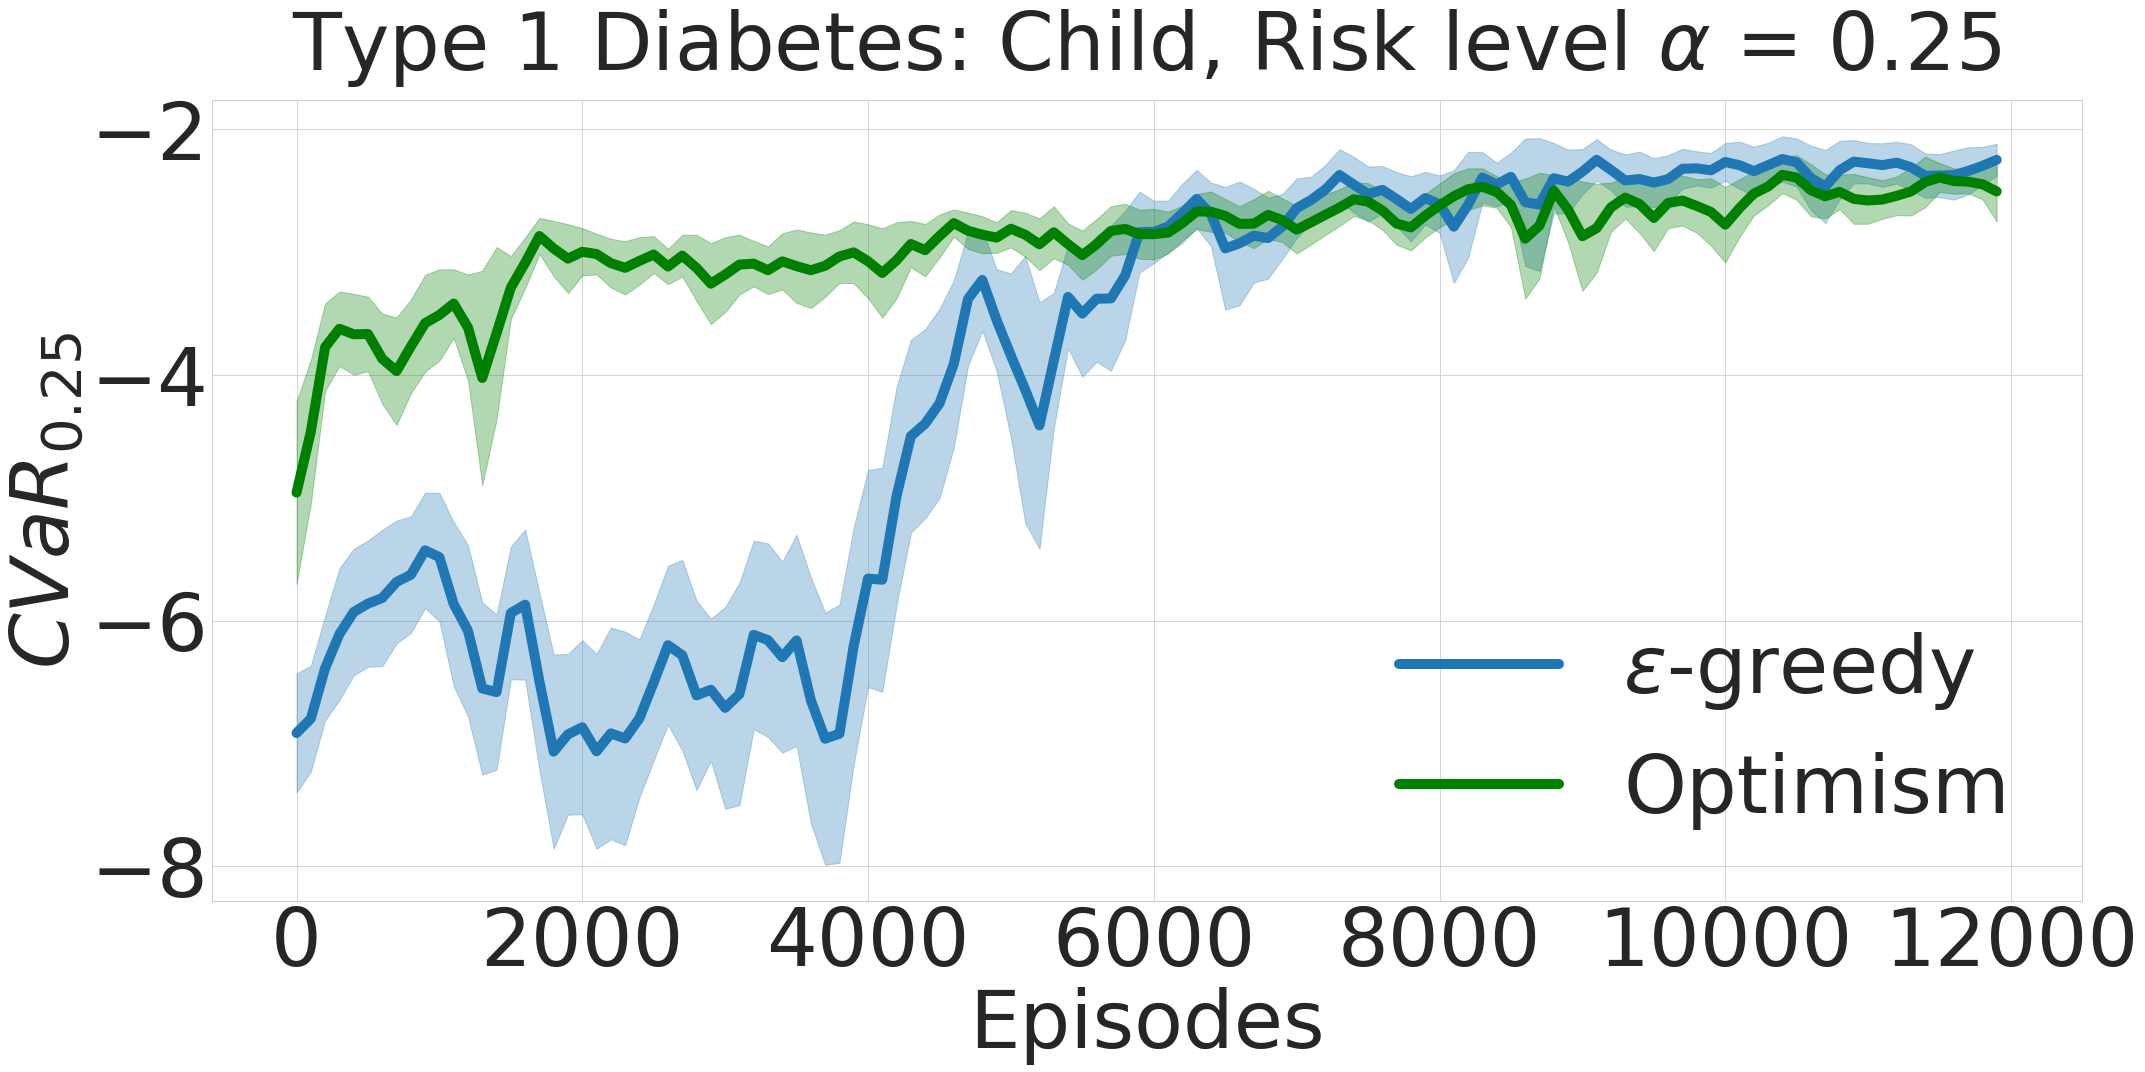

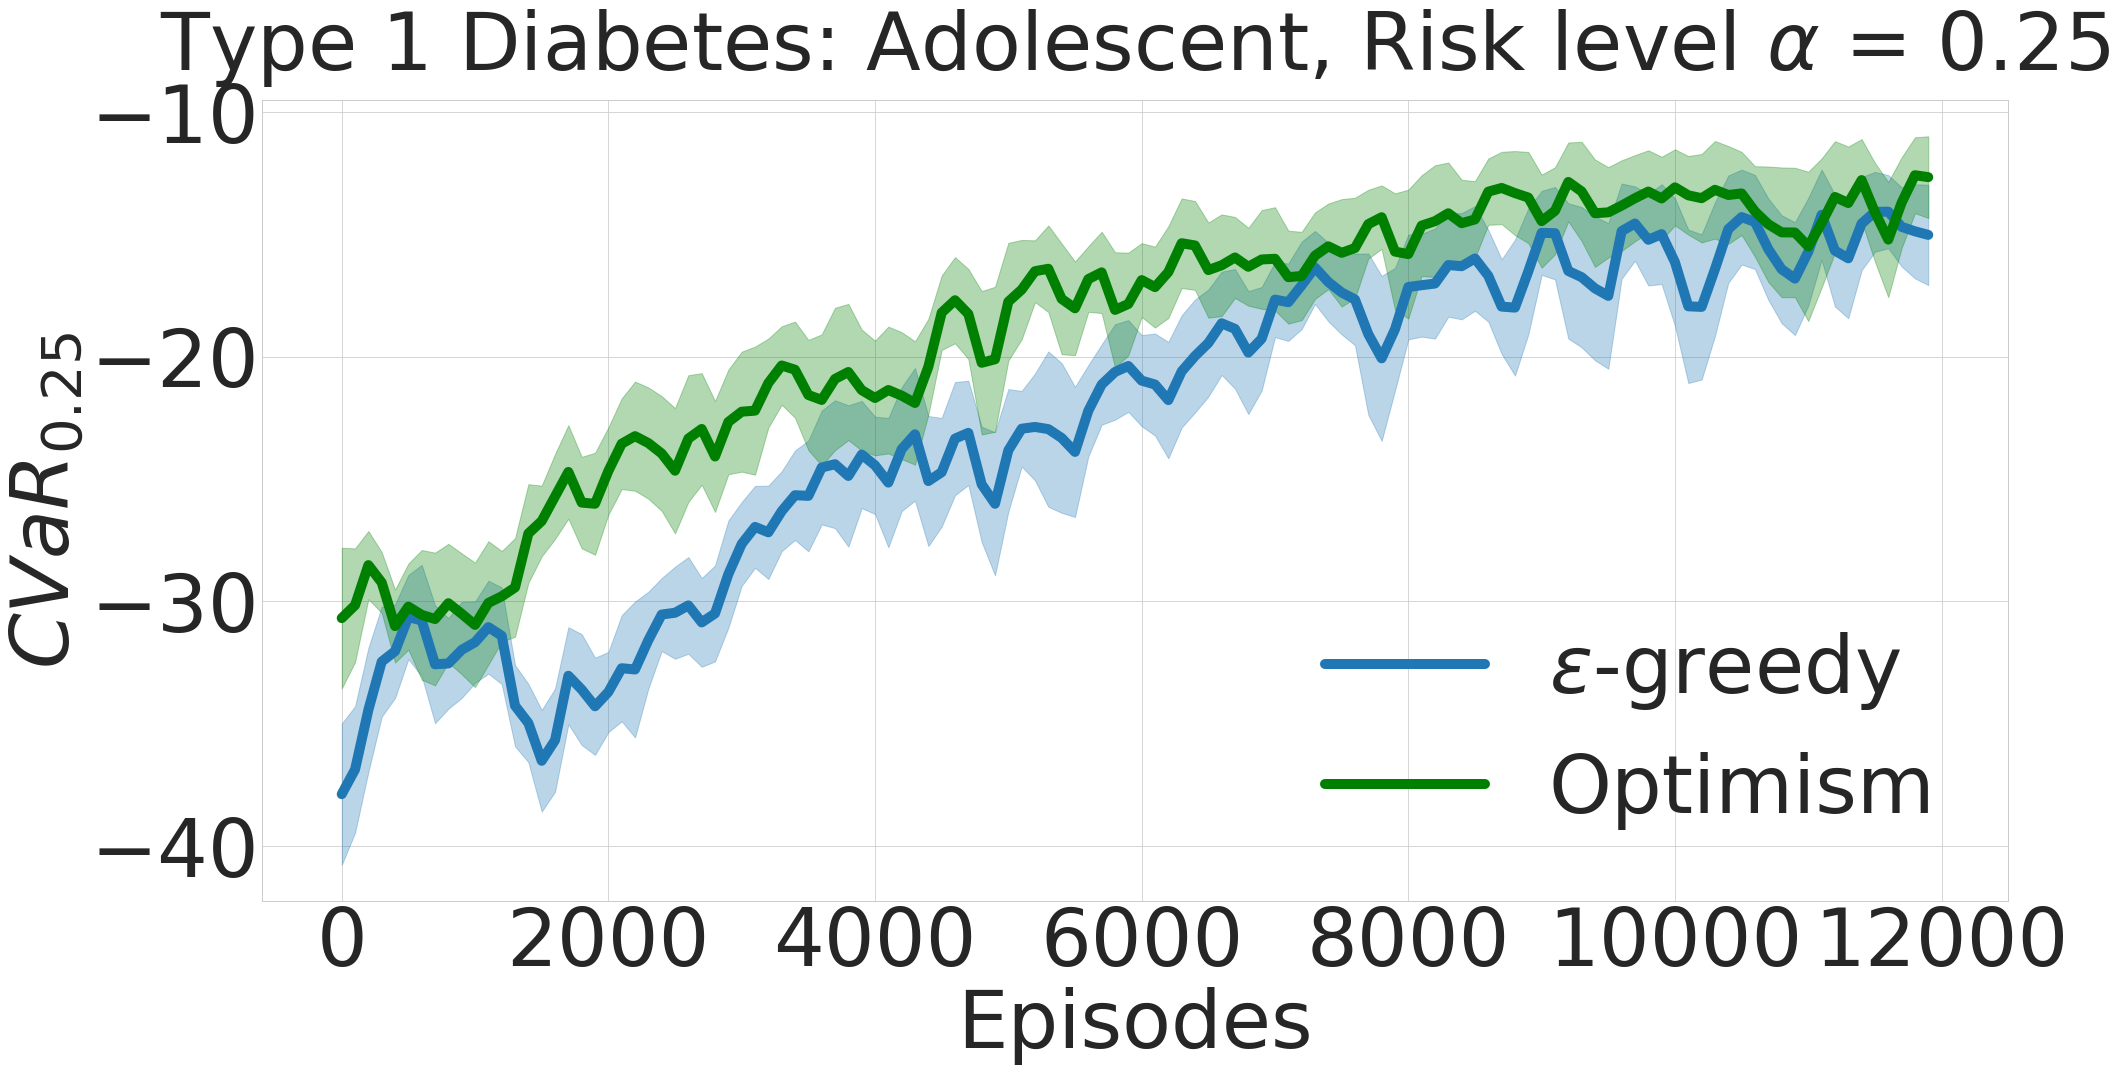

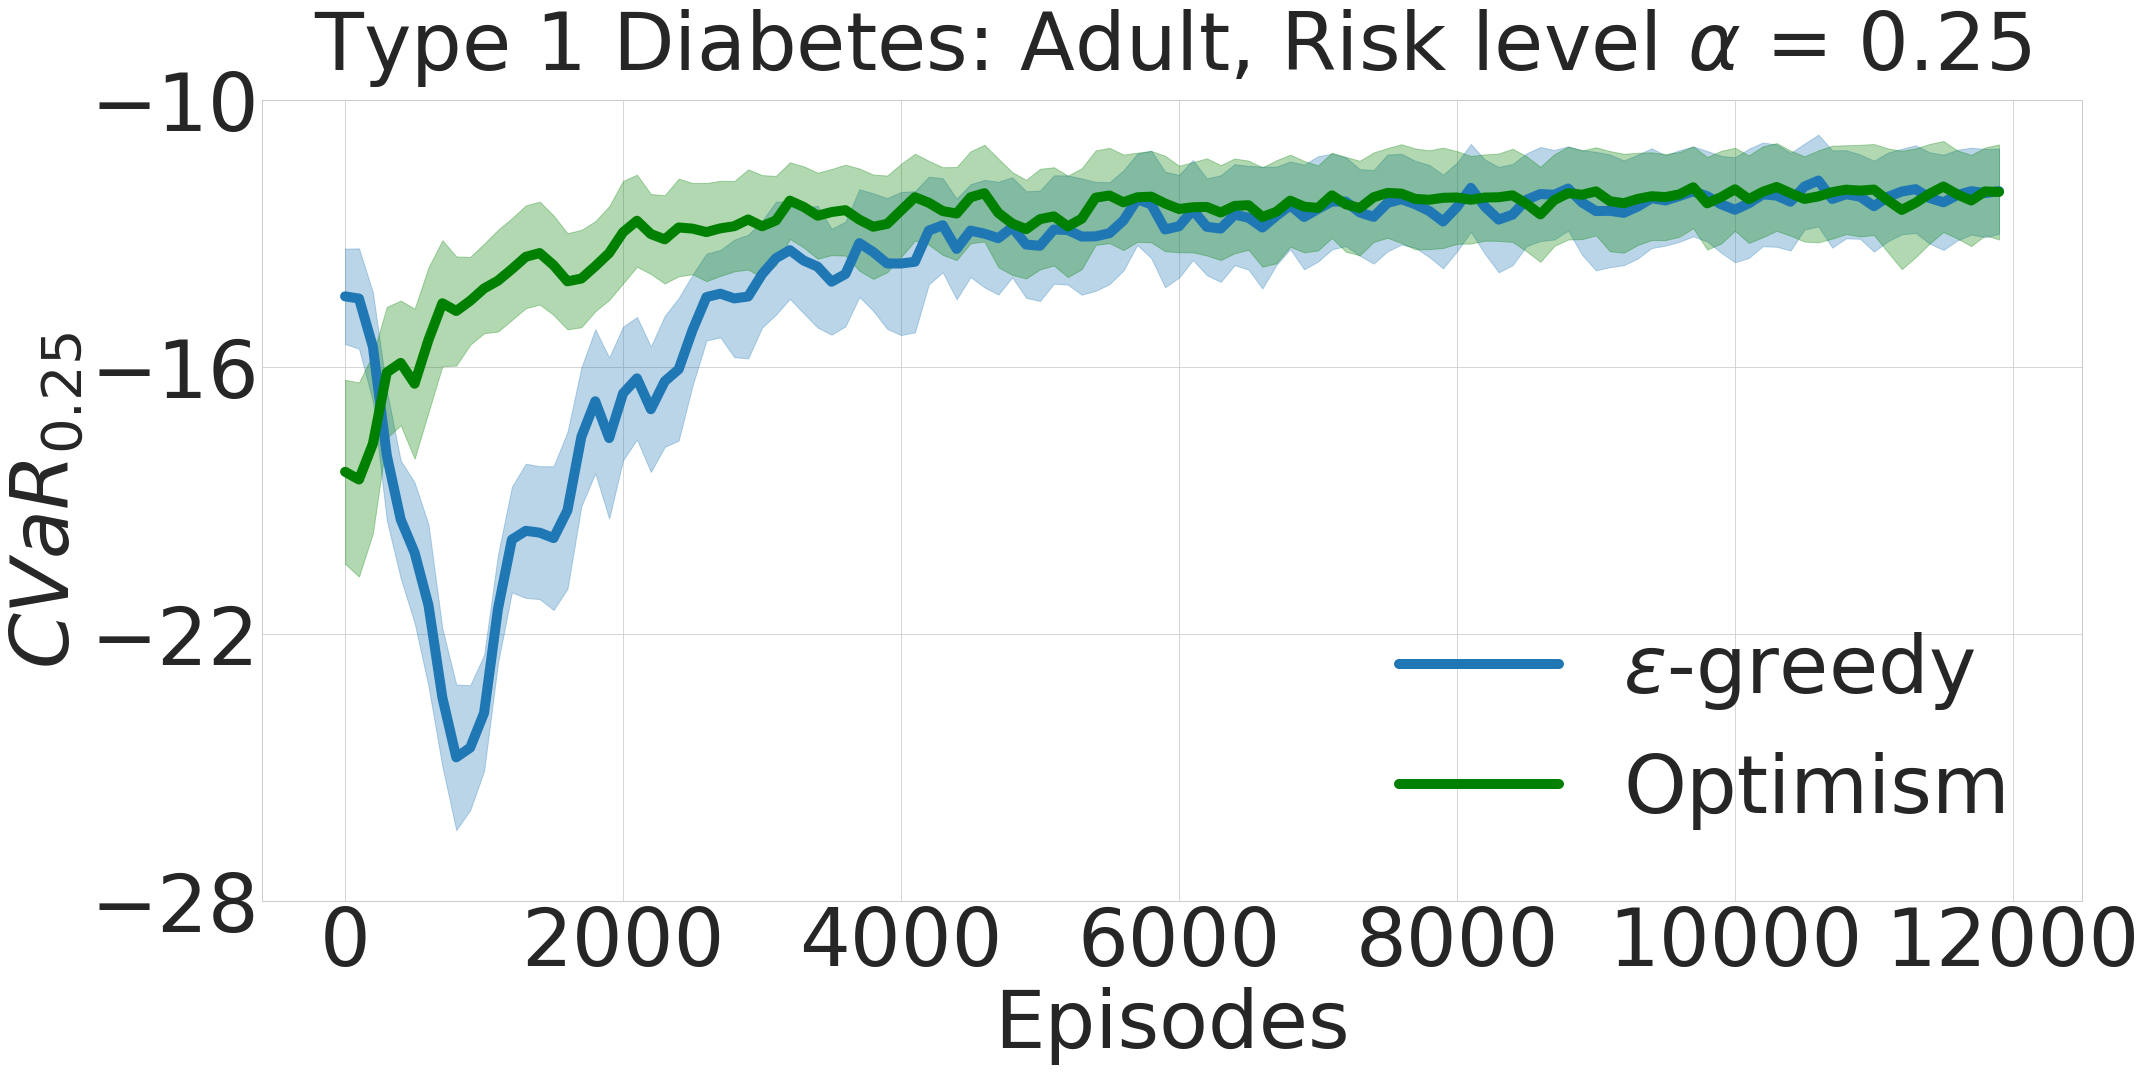

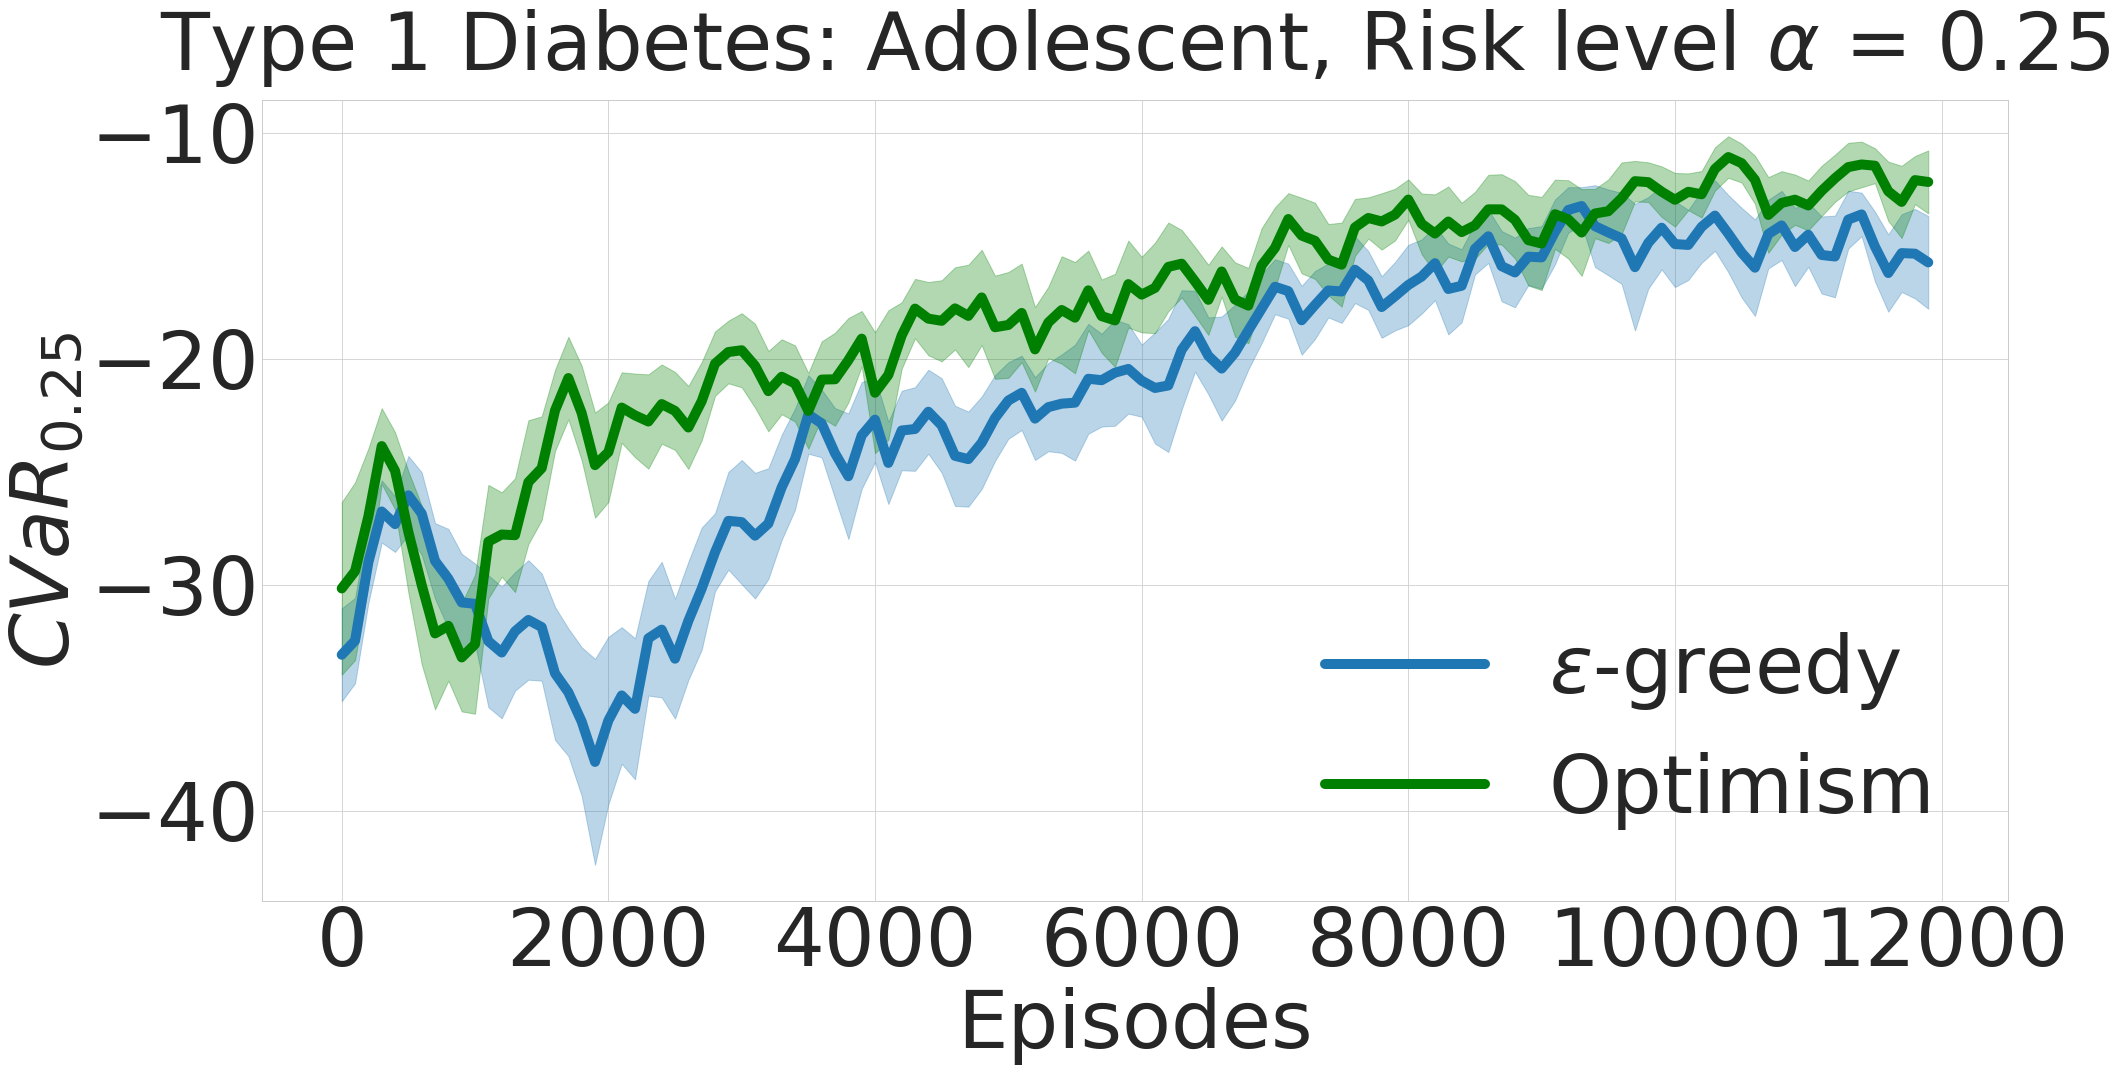

In [33]:
pat = 2
cvs_mean, cvs_std, res, eps = process_egreedy(pat)
cvs_mean_opt4, cvs_std_opt4, res, eps_opt4 = process_opt(pat, 5)
data=[(cvs_mean, cvs_std, eps, 0),\
     (cvs_mean_opt4, cvs_std_opt4, eps_opt4, 4)]
custom_plot(data, pat)

pat = 5
cvs_mean, cvs_std, res, eps = process_egreedy(pat)
cvs_mean_opt, cvs_std_opt, res, eps_opt = process_opt(pat, 5)
data=[(cvs_mean, cvs_std, eps, 0), (cvs_mean_opt, cvs_std_opt, eps_opt, 4)]
custom_plot(data, pat)

pat = 8
cvs_mean, cvs_std, res, eps = process_egreedy(pat)
cvs_mean_opt, cvs_std_opt, res, eps_opt = process_opt(pat, 5)
data=[(cvs_mean, cvs_std, eps, 0), (cvs_mean_opt, cvs_std_opt, eps_opt, 4)]
custom_plot(data, pat)

pat = 6
cvs_mean, cvs_std, res, eps = process_egreedy(pat)
cvs_mean_opt, cvs_std_opt, res, eps_opt = process_opt(pat, 5)
data=[(cvs_mean, cvs_std, eps, 0), (cvs_mean_opt, cvs_std_opt, eps_opt, 4)]
custom_plot(data, pat)

In [ ]:
pat = 5
cvs_mean, cvs_std, res, eps = process_egreedy(pat)
cvs_mean_opt, cvs_std_opt, res, eps_opt = process_opt(pat, 2)
cvs_mean_opt2, cvs_std_opt2, res, eps_opt2 = process_opt(pat, 4)
cvs_mean_opt3, cvs_std_opt3, res, eps_opt3 = process_opt(pat, 8)

data=[(cvs_mean, cvs_std, eps, 0), (cvs_mean_opt, cvs_std_opt, eps_opt, 1),\
      (cvs_mean_opt2, cvs_std_opt2, eps_opt2, 2), (cvs_mean_opt3, cvs_std_opt3, eps_opt3, 3)]
custom_plot(data, pat)

pat = 2
cvs_mean, cvs_std, res, eps = process_egreedy(pat)
cvs_mean_opt, cvs_std_opt, res, eps_opt = process_opt(pat, 2)
cvs_mean_opt2, cvs_std_opt2, res, eps_opt2 = process_opt(pat, 4)
cvs_mean_opt3, cvs_std_opt3, res, eps_opt3 = process_opt(pat, 8)
cvs_mean_opt4, cvs_std_opt4, res, eps_opt4 = process_opt(pat, 5)
data=[(cvs_mean, cvs_std, eps, 0), (cvs_mean_opt, cvs_std_opt, eps_opt, 1),\
      (cvs_mean_opt2, cvs_std_opt2, eps_opt2, 2), (cvs_mean_opt3, cvs_std_opt3, eps_opt3, 3),\
     (cvs_mean_opt4, cvs_std_opt4, eps_opt4, 4)]
custom_plot(data, pat)

pat = 8
cvs_mean, cvs_std, res, eps = process_egreedy(pat)
cvs_mean_opt, cvs_std_opt, res, eps_opt = process_opt(pat, 2)
cvs_mean_opt2, cvs_std_opt2, res, eps_opt2 = process_opt(pat, 4)
cvs_mean_opt3, cvs_std_opt3, res, eps_opt3 = process_opt(pat, 8)
data=[(cvs_mean, cvs_std, eps, 0), (cvs_mean_opt, cvs_std_opt, eps_opt, 1),\
      (cvs_mean_opt2, cvs_std_opt2, eps_opt2, 2), (cvs_mean_opt3, cvs_std_opt3, eps_opt3, 3)]
custom_plot(data, pat, [-30, -10])

### Processing Risk

In [35]:
High = 40
step = 3

In [36]:
def mv(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [37]:
def process_egreedy_risk(patient):
    mv_size = 100
    max_risks = np.zeros((10, 20000))
    avergae_risks = np.zeros((10, 20000))
    
    for i in range(1, 11):
        load_file = np.load('../results_c51/patient_%d_seed_%d_e.p'%(patient, i))
        max_risks[i-1, :] = np.sum(load_file['Risks'] > High, axis=-1) > 20
        avergae_risks[i-1, :] = np.mean(load_file['Risks'], axis=-1)
    ep_risk = np.sum(max_risks, axis=1)        
    risk_mean = mv(np.mean(avergae_risks, axis=0), mv_size)[:-5*mv_size]
    risk_std = mv(np.std(avergae_risks, axis=0), mv_size)[:-5*mv_size]
    ep = np.arange(20000)[:-(6*mv_size)+2]
    return risk_mean, risk_std, ep, np.mean(ep_risk), np.std(ep_risk)

In [38]:
def process_opt_risk(patient, opt):
    mv_size = 100
    max_risks = np.zeros((10, 20000))
    avergae_risks = np.zeros((10, 20000))
    
    for i in range(1, 11):
        load_file = np.load('../results_c51/patient_%d_seed_%d_o%d.p'%(patient, i, opt))
        max_risks[i-1, :] = np.sum(load_file['Risks'] > High, axis=-1) > 20
        avergae_risks[i-1, :] = np.mean(load_file['Risks'], axis=-1)
    ep_risk = np.sum(max_risks, axis=1)
    risk_mean = mv(np.mean(avergae_risks, axis=0), mv_size)[:-5*mv_size]
    risk_std = mv(np.std(avergae_risks, axis=0), mv_size)[:-5*mv_size]
    ep = np.arange(20000)[:-(6*mv_size)+2]
    return risk_mean, risk_std, ep, np.mean(ep_risk), np.std(ep_risk)

In [39]:
def custom_plot_risk(data, patient ,lim=None):
    import seaborn as sns
    from matplotlib.ticker import FormatStrFormatter
    sns.set_style("whitegrid")
    m = 12000
    fontsize = 20
    
    plt.figure(figsize=(10, 5))
    
    grid = plt.GridSpec(1, 3, wspace=0.4, hspace=0.3)
    
    plt.subplot(grid[0, 0:2])
    plt.title('Patient %d'%(patient), fontsize=fontsize)
    for mean, std, eps, _, _ , tit in data:
        label = [r'$\epsilon$-greedy', 'opt 0.2', 'opt 0.4', 'opt 0.8', 'Optimism']
        color = ['blue', 'green', 'green', 'green', 'green']
        plt.plot(eps[:m], mean[:m], label=label[tit], linewidth=2, color=color[tit])
        plt.fill_between(eps[:m], mean[:m]-0.2*std[:m], mean[:m]+0.2*std[:m], alpha=0.2)
    plt.legend(loc=1, fontsize=fontsize)
    plt.ylabel('Average Risk Factor', fontsize=fontsize)
    plt.xlabel('Episodes', fontsize=fontsize)
    
    plt.xticks(fontsize=fontsize, rotation=0)
    plt.yticks(fontsize=fontsize)
    
    ax = plt.subplot(grid[0, 2])
    c = 0
    for _, _, _, risk, risk_std, tit in data:
        plt.bar(c, risk/mean.shape[0], yerr=0.3*risk_std/mean.shape[0], capsize=3, color=color[tit])
        c += 1
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.xticks([0, 1], ['e-greedy', 'optimism'], fontsize=fontsize, rotation=0)
    plt.yticks(fontsize=fontsize)
    plt.ylabel('Fraction of high risk episode', fontsize=fontsize)
    plt.xlabel('Method', fontsize=fontsize)
    plt.savefig('/home/ramtin/Desktop/Risk_Patient_%d.pdf'%(patient), format='pdf')

e-greedy 0.05291479820627802 0.018603407107274504
optimism 0.03311684964692541 0.01691371748042967
e-greedy 0.06600175248698521 0.010658074102308143
optimism 0.040874181743209115 0.010074051230213033


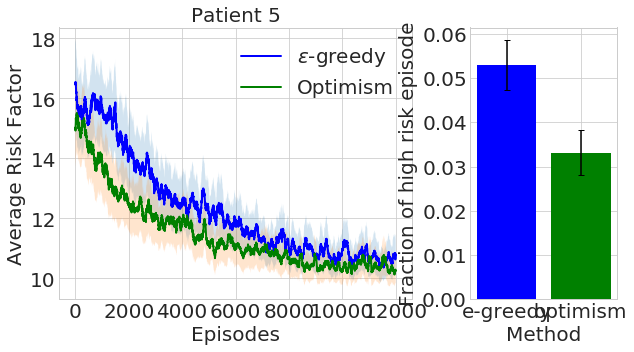

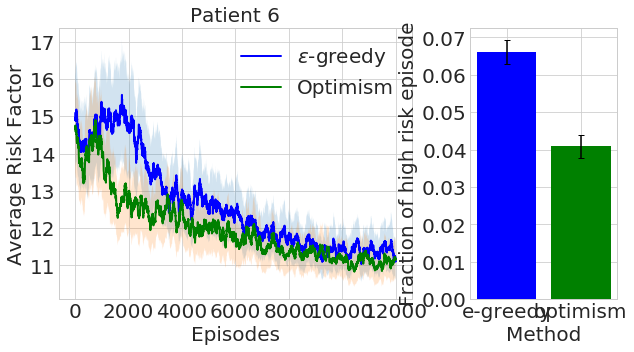

In [40]:
High = 44
pat = 5
mean, std, eps, risk, risk_std= process_egreedy_risk(pat)
mean1, std1, eps1, risk1, risk_std1 = process_opt_risk(pat, 5)
data = [(mean, std, eps, risk, risk_std, 0), (mean1, std1, eps1, risk1, risk_std1, 4)]
custom_plot_risk(data, pat)
print('e-greedy', risk/mean.shape[0], risk_std/mean.shape[0])
print('optimism', risk1/mean.shape[0], risk_std1/mean.shape[0])


pat = 6
mean, std, eps, risk, risk_std = process_egreedy_risk(pat)
mean1, std1, eps1, risk1, risk_std1 = process_opt_risk(pat, 5)
data = [(mean, std, eps, risk, risk_std, 0), (mean1, std1, eps1, risk1, risk_std1, 4)]
custom_plot_risk(data, pat)
print('e-greedy', risk/mean.shape[0], risk_std/mean.shape[0])
print('optimism', risk1/mean.shape[0], risk_std1/mean.shape[0])

e-greedy 0.028215040461831865 0.016073799462995322
optimism 0.024916241430854077 0.014469919240221615


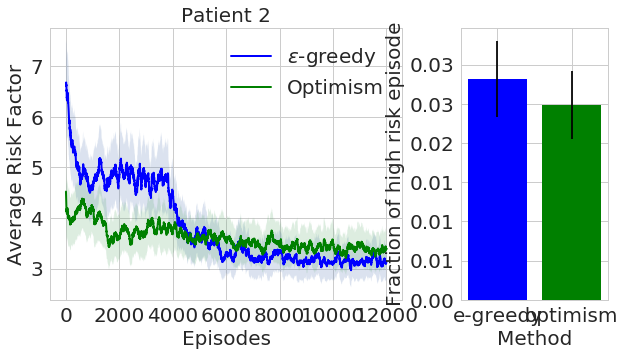

In [581]:
High =35
pat = 2
mean, std, eps, risk, risk_std = process_egreedy_risk(pat)
mean1, std1, eps1, risk1, risk_std1 = process_opt_risk(pat, 5)
data = [(mean, std, eps, risk, risk_std, 0), (mean1, std1, eps1, risk1, risk_std1, 4)]
custom_plot_risk(data, pat)
print('e-greedy', risk/mean.shape[0], risk_std/mean.shape[0])
print('optimism', risk1/mean.shape[0], risk_std1/mean.shape[0])


e-greedy 0.023777124890469563 0.008671643259288424
optimism 0.01524663677130045 0.007579621443077361


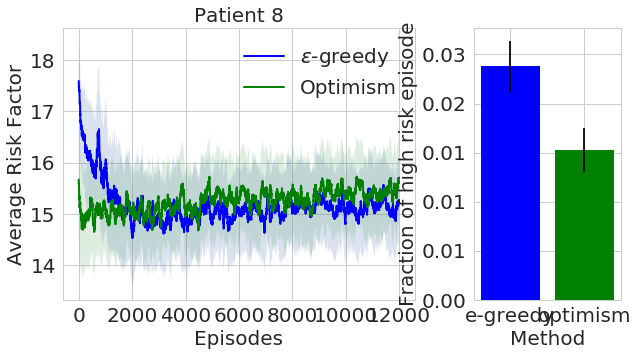

In [582]:
pat = 8
High = 45
mean, std, eps, risk, risk_std = process_egreedy_risk(pat)
mean1, std1, eps1, risk1, risk_std1 = process_opt_risk(pat, 5)
data = [(mean, std, eps, risk, risk_std, 0), (mean1, std1, eps1, risk1, risk_std1, 4)]
custom_plot_risk(data, pat)
print('e-greedy', risk/mean.shape[0], risk_std/mean.shape[0])
print('optimism', risk1/mean.shape[0], risk_std1/mean.shape[0])

## BGs

In [583]:
print((0.28 - 0.24)/0.26)
print((0.53 - 0.33)/(0.53 + 0.33)/2)
print((0.23 - 0.15)/ ((0.23 + 0.15)/2))

0.15384615384615397
0.11627906976744186
0.42105263157894746


In [291]:
def process_egreedy_BG(patient):
    h = H[patient]
    l = L[patient]
    res = np.zeros(10)
    for i in range(1, 11):
        load_file = np.load('../results_c51/patient_%d_seed_%d_e.p'%(patient, i))
        low = np.sum((load_file['BGs']<l) * 1, axis=-1)
        high = np.sum((load_file['BGs']>h) * 1, axis=-1)
        
        low[low > 0] = 1
        high[high > 0] = 1
        tot = low + high
        tot[tot > 0] = 1
        res[i-1] = np.sum(tot)/len(tot)
    return np.mean(res), np.std(res)

In [292]:
def process_opt_BG(patient):
    opt = 5
    h = H[patient]
    l = L[patient]
    res = np.zeros(10)
    for i in range(1, 11):
        load_file = np.load('../results_c51/patient_%d_seed_%d_o%d.p'%(patient, i, opt))
        low = np.sum((load_file['BGs']<l) * 1, axis=-1)
        high = np.sum((load_file['BGs']>h) * 1, axis=-1)
        
        low[low > 0] = 1
        high[high > 0] = 1
        tot = low + high
        tot[tot > 0] = 1
        res[i-1] = np.sum(tot)/len(tot)
    return np.mean(res), np.std(res)

In [293]:
H = {2: 350, 5: 500, 8: 500}
L = {2: 40, 5: 40, 8: 40}

In [294]:
print(process_egreedy_BG(2))
print(process_egreedy_BG(5))
print(process_egreedy_BG(8))

print(process_opt_BG(2))
print(process_opt_BG(5))
print(process_opt_BG(8))

(0.12622, 0.06369494956431003)
(0.560485, 0.10889103739518693)
(0.9534100000000001, 0.05421392256607154)
(0.14557, 0.05614911931633478)
(0.5646950000000001, 0.12745039515435017)
(0.9620850000000001, 0.05208980730430857)


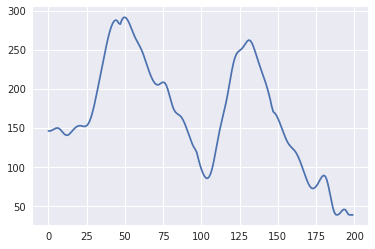

In [262]:
load_file = np.load('../results_c51/patient_%d_seed_%d_e.p'%(5, 1))
plt.plot(load_file['BGs'][20, :])

In [191]:
np.sum(low==0 or high==0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [198]:
low[low > 0] = 1
high[high > 0] = 1
tot = low + high
tot[tot > 0] = 1

In [199]:
np.sum(tot)

11658

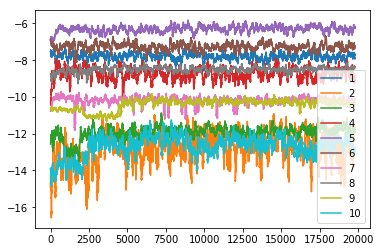

In [79]:
for i in range(1, 11):
    load_file = np.load('../results_c51/patient_%d_seed_%d_o%d.p'%(8, i, 2))
    plt.plot(mv(load_file['returns'], 100)[:-100], label = '%d'%(i))
plt.legend()

In [62]:
load_file.keys()

dict_keys(['p', 'ep', 'returns', 'BGs', 'Risks'])

In [21]:
load_file.keys()

NameError: name 'load_file' is not defined